# Full Angle Coverage Projections (AngCoverage=1.0)

In [1]:
import os
import h5py
from sklearn.neighbors import NearestNeighbors
import numpy as np   
import ipyvolume as ipv
import time

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix

/home/jelena/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jelena/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jelena/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jelena/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: 

## Read generated data

Data was generated with:
```
python generator.py -mrc generated_data/bgal.mrc -num 5000
```

In [2]:
# location of *.h5 files
data_dir = "../generated_data"

# full coverage (AngCoverage=1.0)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage1.0_AngShift0.00"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

## No Noise

In [3]:
projections = data["Projections"]

## k-NN on **projections**

In [4]:
projections.shape

(5000, 136, 136)

In [5]:
X = np.reshape(projections, (projections.shape[0], -1))
X.shape

(5000, 18496)

In [6]:
start_time = time.time()

if not os.path.exists(f'data/{projections_filename}_distances.npy'):
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.kneighbors(X)
    connections = nbrs.kneighbors_graph(X).toarray()
    
    np.save(f'data/{projections_filename}_indices', indices)         # Indices of the nearest points in the population matrix
    np.save(f'data/{projections_filename}_distances', distances)     # Array representing the lengths to points
    np.save(f'data/{projections_filename}_connections', connections) # Sparse graph showing the connections between neighboring points
    
else:
    indices     = np.load(f'data/{projections_filename}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
    distances   = np.load(f'data/{projections_filename}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
    connections = np.load(f'data/{projections_filename}_connections.npy') # shape: NUM_IMGS, NUM_IMGS
    
print(f"--- {time.time() - start_time} seconds ---")

--- 0.4021165370941162 seconds ---


In [7]:
connections.shape

(5000, 5000)

In [8]:
indices[0]

array([   0, 4070, 3366, 3389, 3590])

In [9]:
distances[0]

array([ 0.        , 30.12180071, 46.68404119, 49.91995934, 50.45942721])

### Plot similar projections

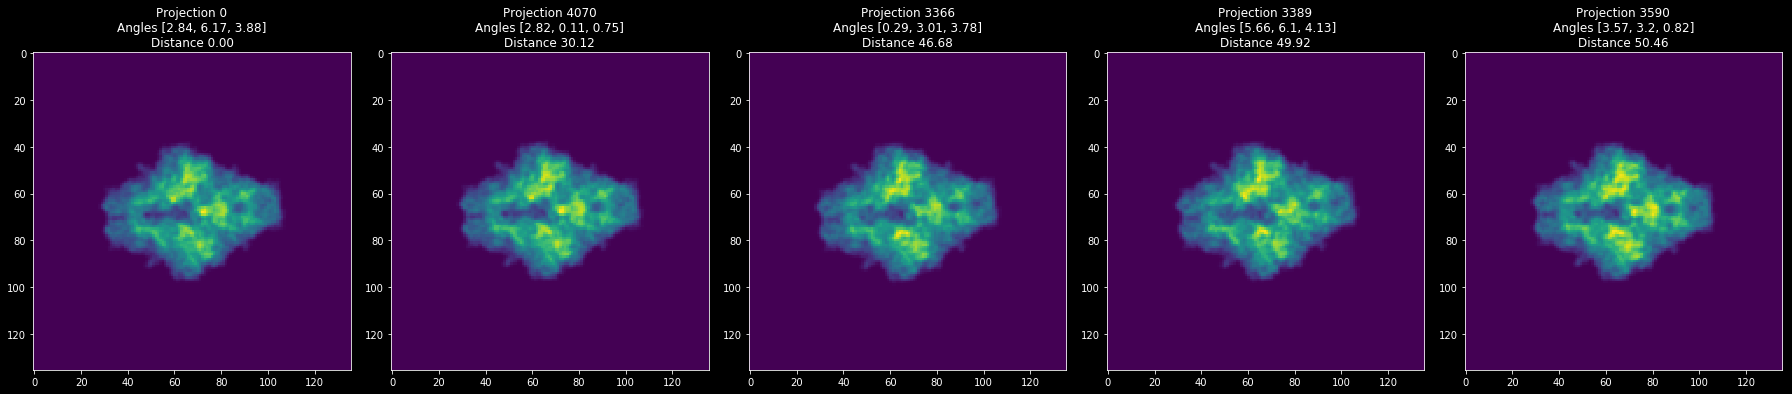

In [10]:
indices1 = indices[0]
distances1 = distances[0]

nrows, ncols = 1, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for datapoint, distance in zip(indices1, distances1):
    image = projections[datapoint]
    image = image #+ gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}\nDistance {distance:.2f}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

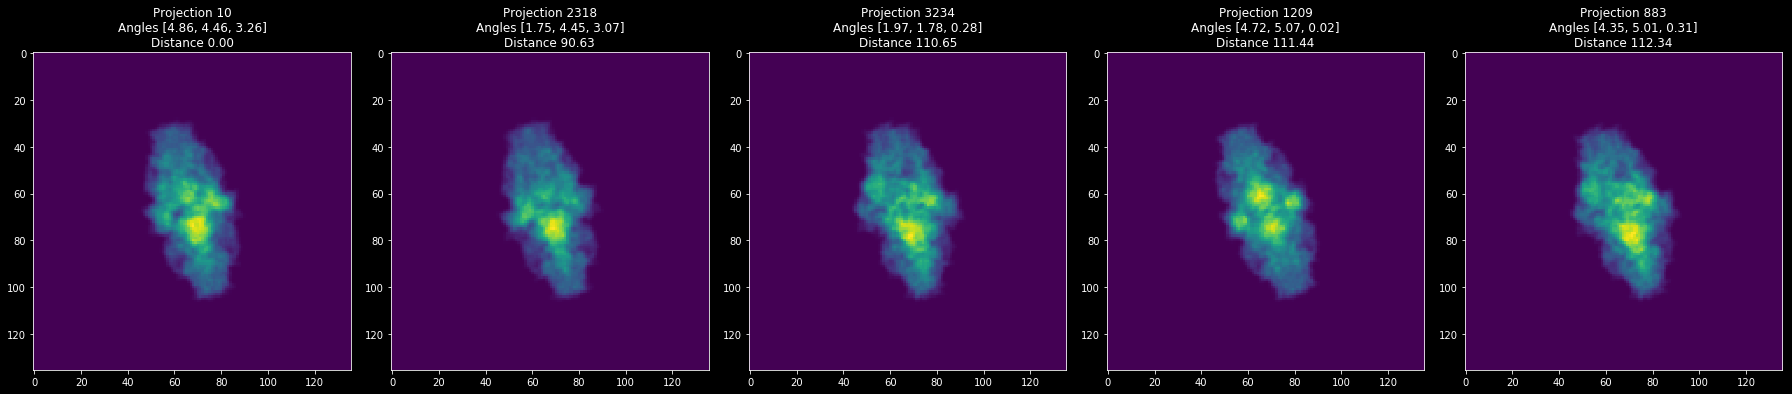

In [11]:
indices1 = indices[10]
distances1 = distances[10]

nrows, ncols = 1, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for datapoint, distance in zip(indices1, distances1):
    image = projections[datapoint]
    image = image #+ gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}\nDistance {distance:.2f}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

#### Without Rotation Matrix

In [12]:
indices1 = indices[10]

knn_vectors = np.take(data["Angles"], indices1, axis=0)
all_vectors = np.delete(data["Angles"], indices1, 0)

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()

#### With Rotation Matrix

In [13]:
indices1 = indices[10]

knn_vectors = RotationMatrix(np.take(data["Angles"], indices1, axis=0))
all_vectors = RotationMatrix(np.delete(data["Angles"], indices1, 0))

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()

---

# Quaternions

Visualizing **SO(3) space**. Following explaination in [wiki](https://en.wikipedia.org/wiki/3D_rotation_group#Topology).

How to use [pyquaternions](http://kieranwynn.github.io/pyquaternion/).


In [14]:
from pyquaternion import Quaternion

## One Quaternion

In [15]:
angle1 = data["Angles"][0]
angle1

array([2.84289246, 6.17066426, 3.88191103])

In [16]:
qx = Quaternion(axis=[1, 0, 0], angle=angle1[0])
qy = Quaternion(axis=[0, 1, 0], angle=angle1[1])
qz = Quaternion(axis=[0, 0, 1], angle=angle1[2])

In [17]:
# compose rotations above
q = qx*qy*qz
q.axis, q.angle

(array([ 0.36497154,  0.91740793, -0.15861419]), 3.1377828346199053)

In [18]:
point = list(map(lambda x: np.array([x * q.angle]), q.axis))
point

[array([1.14520143]), array([2.87862687]), array([-0.49769687])]

## All Quaternions

In [19]:
def quaternion(angle):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    qx = Quaternion(axis=[1, 0, 0], angle=angle[0])
    qy = Quaternion(axis=[0, 1, 0], angle=angle[1])
    qz = Quaternion(axis=[0, 0, 1], angle=angle[2])
    
    # compose rotations above
    q = qx*qy*qz

    return q

In [20]:
def quaternion2point(q):
    """ Convert Quaternion to point
    
    We convert Qaternion to the point described with x, y, z values in the Cartesian coordinate system.
    From the Qaternion we get axis and angle. The axis is described as unit vector (ux, uy, uz) and the angle is magnitude of vector.
    Using this two information, we can get the x, y, z coordinates of the point described with axis and angle.
    """
    point = np.array(list(map(lambda x: x * q.angle, q.axis)))
    return point

In [21]:
points = np.zeros(data["Angles"].shape)

for idx, angles in enumerate(data["Angles"]):
    point = quaternion2point(quaternion(angles))
    points[idx, :] = point

points

array([[ 1.14520143,  2.87862687, -0.49769687],
       [-0.0255854 ,  1.70666408,  0.50365408],
       [ 1.76613522, -0.89022903, -1.85286745],
       ...,
       [ 0.10217428, -1.17434007, -0.60002669],
       [ 0.6509479 ,  1.37844962,  0.74344676],
       [ 0.66378432, -1.26826664, -1.52398715]])

In [22]:
ipv.figure(width=500, height=400)
ipv.scatter(points[:, 0], points[:, 1], points[:, 2], marker="sphere", color="blue", size=1.5)
ipv.show()

---

# kNN results in the SO(3)

In [23]:
indices1 = indices[0]

knn_vectors = np.take(points, indices1, axis=0)
all_vectors = np.delete(points, indices1, 0)

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()